In [ ]:
import pandas as pd
from datetime import datetime
import baostock as bs
import os
import openpyxl

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


def get_stock_data(stock_code,start_date,end_date,frequency):
    """
    stock_code：
    start_date：string,
    end_date：string,
    frequency：
    """

    lg = bs.login()
    rs = bs.query_history_k_data_plus(stock_code,
        "date,time,code,open,high,low,close,volume,amount,adjustflag",
        start_date=start_date, end_date=end_date,
        frequency=frequency, adjustflag="3")
    #### 打印结果集 ####
    data_list = []
    while (rs.error_code == '0') & rs.next():
        # 获取一条记录，将记录合并在一起
        data_list.append(rs.get_row_data())
        print(rs.get_row_data())
    result = pd.DataFrame(data_list, columns=rs.fields)
    bs.logout()
    return result

def update_data(stock_code,frequency):
    """
    更新数据，取数据表中的最后日期为start_date，至今为end_date，若start_date==end_date,则不更新
    stock_code：
    start_date：
    end_date：
    frequency：
    """
    directory_path = "../Data/"

    df = pd.read_excel("../Data/股票信息.xlsx")
    excel_name = df.loc[df['code']==stock_code,'code_name'].iloc[0]
    excel_name = f"{excel_name}最新数据.xlsx"
    file_path = os.path.join(directory_path, excel_name)

    if not os.path.isfile(file_path):
        #没数据新建数据
        start_date = df.loc[df['code']==stock_code,'ipoDate'].astype(str).values[0]
        print(f"{stock_code}啊{start_date}至{datetime.now().strftime('%Y-%m-%d')}{frequency}")
        print(f"{excel_name}数据新建中..")
        data = get_stock_data(stock_code,start_date,datetime.now().strftime('%Y-%m-%d'),'5')
        data.to_excel(file_path, index=False)
        print(f"{excel_name}数据已新建")
    else:
        #有数据更新数据
        data = pd.read_excel(file_path)
        data['date'] = data['date'].astype(str)
        start_date = pd.to_datetime(data['date'], format = "%Y-%m-%d", errors='coerce').max().strftime('%Y-%m-%d') #取数据表中的最后日期
        # ------------这里有个坑
        end_date = datetime.now().strftime('%Y-%m-%d') #至今
        
        if start_date != end_date:
            
            result = get_stock_data(stock_code,start_date,end_date,frequency)
            with pd.ExcelWriter(file_path, mode='a', engine='openpyxl', if_sheet_exists='overlay') as writer:
                result.to_excel(writer, sheet_name='Sheet1', index=False)
            print(f"{excel_name}数据已更新")
        else:
            print(f"{excel_name}数据已是最新")
    
    
    

    

In [13]:
df = get_stock_data("sh.601162","2025-06-02","2025-06-06",'d')

login success!
logout success!


In [14]:
print(df.shape)

(0, 0)


In [71]:
df = pd.read_excel("../Data/股票信息.xlsx")

In [97]:
df.loc[df['code_name'].str.contains("天风证券"),:]
df.loc[df['code_name'].str.contains("光大嘉宝"),:]
df.loc[df['code_name'].str.contains("常山北明"),:]
df.loc[df['code_name'].str.contains("蓝黛科技"),:]
df.loc[df['code']=='sh.601162','ipoDate'].astype(str).values[0]

,Unnamed: 0,code,code_name,ipoDate,outDate,type,status
2747,2747,sh.601162,天风证券,2018-10-19,NaN,1,1


,Unnamed: 0,code,code_name,ipoDate,outDate,type,status
2348,2348,sh.600622,光大嘉宝,1992-12-03,NaN,1,1


,Unnamed: 0,code,code_name,ipoDate,outDate,type,status
4281,4281,sz.000158,常山北明,2000-07-24,NaN,1,1


,Unnamed: 0,code,code_name,ipoDate,outDate,type,status
5565,5565,sz.002765,蓝黛科技,2015-06-12,NaN,1,1


'2018-10-19'

In [100]:
#update_data("sh.601162","5")
update_data("sh.600622","5") #光大嘉宝：sh.600622
update_data("sh.600900","5") #长江电力：sh.600900
update_data("sz.002765","5") #蓝黛科技：sz.002765
update_data("sz.000158","5") #常山北明：sz.000158


#update_data("sh.600900","5") #：sh.600900

#上证综指：sh.000001
#中油资本：sz.000617

#天风证券：sh.601162
#中信证券：sh.600030
#国金证券：sh.600109




login success!
logout success!
光大嘉宝最新数据.xlsx数据已更新
login success!
logout success!
长江电力最新数据.xlsx数据已更新
sz.002765啊2015-06-12至2024-12-255
蓝黛科技最新数据.xlsx数据新建中..
login success!
logout success!
蓝黛科技最新数据.xlsx数据已新建
sz.000158啊2000-07-24至2024-12-255
常山北明最新数据.xlsx数据新建中..
login success!
logout success!
常山北明最新数据.xlsx数据已新建


In [6]:
%pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


# 抓取所有股票数据-working

In [ ]:
# 获取分时数据
#### 登陆系统 ####
lg = bs.login()
# 获取证券信息
rs = bs.query_all_stock(day="2024-10-29")
stock_df = rs.get_data()

# 准备一个空的DataFrame来存储股票的开始时间信息
start_times = pd.DataFrame()

# 遍历所有股票，获取每只股票的开始时间
data_list = []
for stcode in stock_df["code"]:
    tlist = []
    # 获取单只股票的历史K线数据
    time.sleep(0.2)
    #codename = stock_df.loc[stock_df.code==stcode,"code_name"]
    k_rs = bs.query_history_k_data_plus(stcode, "date,code,open,high,low,close",
        start_date="1990-12-19", end_date="2024-10-29", frequency="5", adjustflag="3")
    while (k_rs.error_code == '0') & k_rs.next():
    # 获取一条记录，将记录合并在一起
        tlist.append(rs.get_row_data())
    data_list.append(tlist)


login success!


MemoryError: 

# 所有股票信息

In [14]:
import baostock as bs
import pandas as pd

# 登录Baostock
lg = bs.login()

# 显示登录返回信息
print('login respond error_code: ' + lg.error_code)
print('login respond error_msg: ' + lg.error_msg)

# 获取证券基本资料
# 这里我们查询所有A股股票的基本信息
rs = bs.query_stock_basic()

# 打印错误信息
print('query_stock_basic respond error_code: ' + rs.error_code)
print('query_stock_basic respond error_msg: ' + rs.error_msg)

# 获取查询结果
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)

# 打印结果集
# 登出系统
bs.logout()


login success!
login respond error_code: 0
login respond error_msg: success
query_stock_basic respond error_code: 0
query_stock_basic respond error_msg: success
           code   code_name     ipoDate outDate type status
0     of.159001   易方达保证金货币A  2013-03-29            5      1
1     of.159003    招商保证金快线A  2013-05-17            5      1
2     of.159005  汇添富收益快钱货币A  2014-12-23            5      1
3     of.159150  易方达深证50ETF  2023-11-29            5      1
4     of.159300  富国沪深300ETF  2024-05-23            5      1
...         ...         ...         ...     ...  ...    ...
8131  sz.399994  中证信息安全主题指数  2015-03-12            2      1
8132  sz.399995    中证基建工程指数  2015-03-12            2      1
8133  sz.399996    中证智能家居指数  2014-09-17            2      1
8134  sz.399997      中证白酒指数  2015-01-21            2      1
8135  sz.399998      中证煤炭指数  2015-02-13            2      1

[8136 rows x 6 columns]
logout success!


In [15]:
result.to_excel("../Data/股票信息.xlsx")
result[result['code']=='sh.600622']

,code,code_name,ipoDate,outDate,type,status
2348,sh.600622,光大嘉宝,1992-12-03,,1,1


# 获取单只股日k数据

In [ ]:
stock_code = "sh.600622"

start_date='2021-01-01'; end_date='2022-01-01'
frequency="5"
# 详细指标参数，参见“历史行情指标参数”章节；“分钟线”参数与“日线”参数不同。“分钟线”不包含指数。
# 分钟线指标：date,time,code,open,high,low,close,volume,amount,adjustflag
# 周月线指标：date,code,open,high,low,close,volume,amount,adjustflag,turn,pctChg
df = get_stock_data(stock_code,start_date,end_date,frequency)
df.to_excel("../Data/光大嘉宝最新数据.xlsx")


login success!
logout success!


```python
rs = bs.query_history_k_data_plus("sh.600000",
    "date,time,code,open,high,low,close,volume,amount,adjustflag",
    start_date='2017-07-01', end_date='2017-07-31',
    frequency="5", adjustflag="3")
```
参数含义：
code：股票代码，sh或sz.+6位数字代码，或者指数代码，如：sh.601398。sh：上海；sz：深圳。此参数不可为空；
fields：指示简称，支持多指标输入，以半角逗号分隔，填写内容作为返回类型的列。详细指标列表见历史行情指标参数章节，日线与分钟线参数不同。此参数不可为空；
start：开始日期（包含），格式“YYYY-MM-DD”，为空时取2015-01-01；
end：结束日期（包含），格式“YYYY-MM-DD”，为空时取最近一个交易日；
frequency：数据类型，默认为d，日k线；d=日k线、w=周、m=月、5=5分钟、15=15分钟、30=30分钟、60=60分钟k线数据，不区分大小写；指数没有分钟线数据；周线每周最后一个交易日才可以获取，月线每月最后一个交易日才可以获取。
adjustflag：复权类型，默认不复权：3；1：后复权；2：前复权。已支持分钟线、日线、周线、月线前后复权。 BaoStock提供的是涨跌幅复权算法复权因子，具体介绍见：复权因子简介或者BaoStock复权因子简介。

注意：
股票停牌时，对于日线，开、高、低、收价都相同，且都为前一交易日的收盘价，成交量、成交额为0，换手率为空。
如果需要将换手率转为float类型，可使用如下方法转换：result["turn"] = [0 if x == "" else float(x) for x in result["turn"]]

关于复权数据的说明：
BaoStock使用“涨跌幅复权法”进行复权，详细说明参考上文“复权因子简介”。不同系统间采用复权方式可能不一致，导致数据不一致。
“涨跌幅复权法的”优点：可以计算出资金收益率，确保初始投入的资金运用率为100%，既不会因为分红而导致投资减少，也不会因为配股导致投资增加。

# 获取单只股分时数据

In [51]:
lg = bs.login()

rs = bs.query_history_k_data_plus("sh.600622",
    "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST",
    start_date='2020-01-01', end_date='2023-01-01',
    frequency="5", adjustflag="3")
print('query_history_k_data_plus respond error_code:'+rs.error_code)
print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)

#### 打印结果集 ####
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)

#### 结果集输出到csv文件 ####   
result.to_excel("../Data/光大嘉宝最新数据.xlsx", index=False)

login success!
query_history_k_data_plus respond error_code:10004012
query_history_k_data_plus respond  error_msg:5分钟线指标参数传入错误:preclose


<Figure size 32000x24000 with 0 Axes>

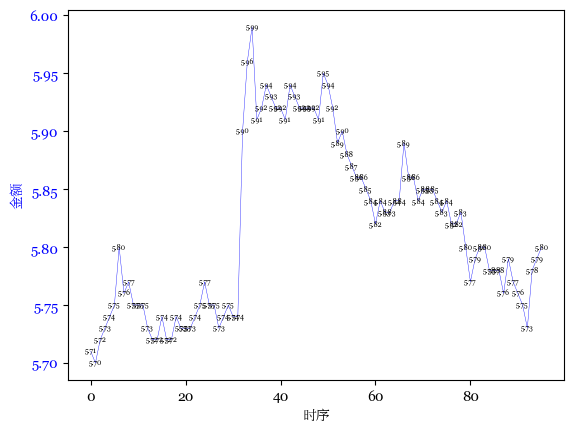

In [ ]:
df['close'] = df['close'].astype('float')
# 绘制第一个图：测试集图
fig = plt.figure(figsize=(20, 5))  # 设置图形的大小
fig, ax1 = plt.subplots()
_=ax1.plot(df.close, label='amount',lw=0.27, color = 'blue')  # 绘制测试集

for i in range(len(df.close)):
    _=ax1.text(df.close.index[i], df.close[i], f"{df.close[i]:.2f}", ha='center', va='center',fontsize = 5)  # 绘制测试集

#_=ax1.bar(df.time,df.close, label='amount',lw=0.27, color = 'blue')  # 绘制测试集
#_=ax1.scatter(pd.DataFrame(dtest_y).reset_index(0)['close'].index, pd.DataFrame(dtest_y).reset_index(0)['close'], s=0.1, edgecolors='blue', facecolors='none', marker='o',lw=0.025)
_=ax1.set_xlabel('时序')
_=ax1.set_ylabel('金额', color='b')
_=ax1.tick_params(axis='y', labelcolor='b')


# # 创建第二个Y轴
# ax2 = ax1.twinx()

# # 绘制第二个图：收盘价及买卖点位
# _=ax2.plot(df.iloc[:,7].index, prediction2.predictions, label='Prediction',lw=0.05, color = 'black')  # 绘制预测值

# plt.savefig('backtest_01.svg', format='svg')